Notebook showing usage of the data detective.

In [1]:
# To import detective from relative folder
import detective.core as detective
import detective.functions as functions
import pandas as pd

Supply the db_url as described in the [recorder integration docs](https://www.home-assistant.io/integrations/recorder/).

In [2]:
db_url = "sqlite:////Users/robin/.homeassistant/home-assistant_v2.db"

In [3]:
db = detective.HassDatabase(db_url) # To init without fetching entities fetch_entities=False

Successfully connected to database sqlite:////Users/robin/.homeassistant/home-assistant_v2.db
There are 254 entities with data


Alternatively, detective can discover your database credentials

In [4]:
db = detective.db_from_hass_config()

Successfully connected to database sqlite:////Users/robin/.homeassistant/home-assistant_v2.db
There are 254 entities with data


Entities are listed on an attribute

In [5]:
db.entities[:10]

['alarm_control_panel.blink_amberwood',
 'automation.fish_tank_light_off',
 'automation.fish_tank_light_on',
 'automation.front_door_motion',
 'automation.garden_light_off',
 'automation.garden_light_on',
 'automation.object_detection_automation',
 'automation.porch_deepstack',
 'automation.porch_light_off',
 'automation.run_rekognition_text_every_hour']

Use `fetch_all_data_of()` to get data for a single entity

In [6]:
df = db.fetch_all_data_of(('sensor.netatmo_netatmo_temperature',))

The returned Pandas dataframe has 495 rows of data.


In [7]:
df.head()

,entity_id,state,last_updated
0,sensor.netatmo_netatmo_temperature,20.4,2022-10-20 05:15:01.619494
1,sensor.netatmo_netatmo_temperature,20.4,2022-10-20 05:13:00.905005
2,sensor.netatmo_netatmo_temperature,20.2,2022-10-20 05:03:00.251738
3,sensor.netatmo_netatmo_temperature,20.1,2022-10-20 04:52:00.257237
4,sensor.netatmo_netatmo_temperature,19.9,2022-10-20 04:41:00.264114


Use `fetch_all_sensor_data()` to fetch all your sensor data into a pandas dataframe in memory. Note that by default the number of states returned is limited but this can optionally be over-ridden as shown below. 

In [8]:
df = db.fetch_all_sensor_data(limit=100000)

The returned Pandas dataframe has 100000 rows of data.


Take a minute to read about the differences between [wide-form and long-form data](https://altair-viz.github.io/user_guide/data.html#long-form-vs-wide-form-data). The Pandas dataframe we have is in long form.

In [9]:
df.head()

,entity_id,state,last_updated
0,sensor.wemo_insight_current_power,4.55,2022-10-20 05:17:36.687928
1,sensor.wemo_insight_current_power,4.54,2022-10-20 05:17:34.175758
2,sensor.wemo_insight_current_power,4.52,2022-10-20 05:17:31.663184
3,sensor.wemo_insight_current_power,4.57,2022-10-20 05:17:29.151387
4,sensor.wemo_insight_current_power,4.58,2022-10-20 05:17:27.643869


It is necessary to format the data before we can plot it, and detective provides a functions to assist

In [10]:
df = functions.format_dataframe(df)

In [11]:
df.head()

,entity_id,state,last_updated
0,sensor.wemo_insight_current_power,4.55,2022-10-20 05:17:36.687928
1,sensor.wemo_insight_current_power,4.54,2022-10-20 05:17:34.175758
2,sensor.wemo_insight_current_power,4.52,2022-10-20 05:17:31.663184
3,sensor.wemo_insight_current_power,4.57,2022-10-20 05:17:29.151387
4,sensor.wemo_insight_current_power,4.58,2022-10-20 05:17:27.643869


It is straightforward to create your own features, for example to add a `day_of_week` column

In [12]:
df['day_of_week'] = df['last_updated'].apply(lambda x : x.dayofweek)
df['is_temperature'] = df['entity_id'].apply(lambda x : 'temperature' in x)

In [13]:
df.head()

,entity_id,state,last_updated,day_of_week,is_temperature
0,sensor.wemo_insight_current_power,4.55,2022-10-20 05:17:36.687928,3,False
1,sensor.wemo_insight_current_power,4.54,2022-10-20 05:17:34.175758,3,False
2,sensor.wemo_insight_current_power,4.52,2022-10-20 05:17:31.663184,3,False
3,sensor.wemo_insight_current_power,4.57,2022-10-20 05:17:29.151387,3,False
4,sensor.wemo_insight_current_power,4.58,2022-10-20 05:17:27.643869,3,False


## Plot some data
First plot using [Seaborn](https://seaborn.pydata.org/)

In [14]:
# !pip install seaborn # Uncomment to install if required

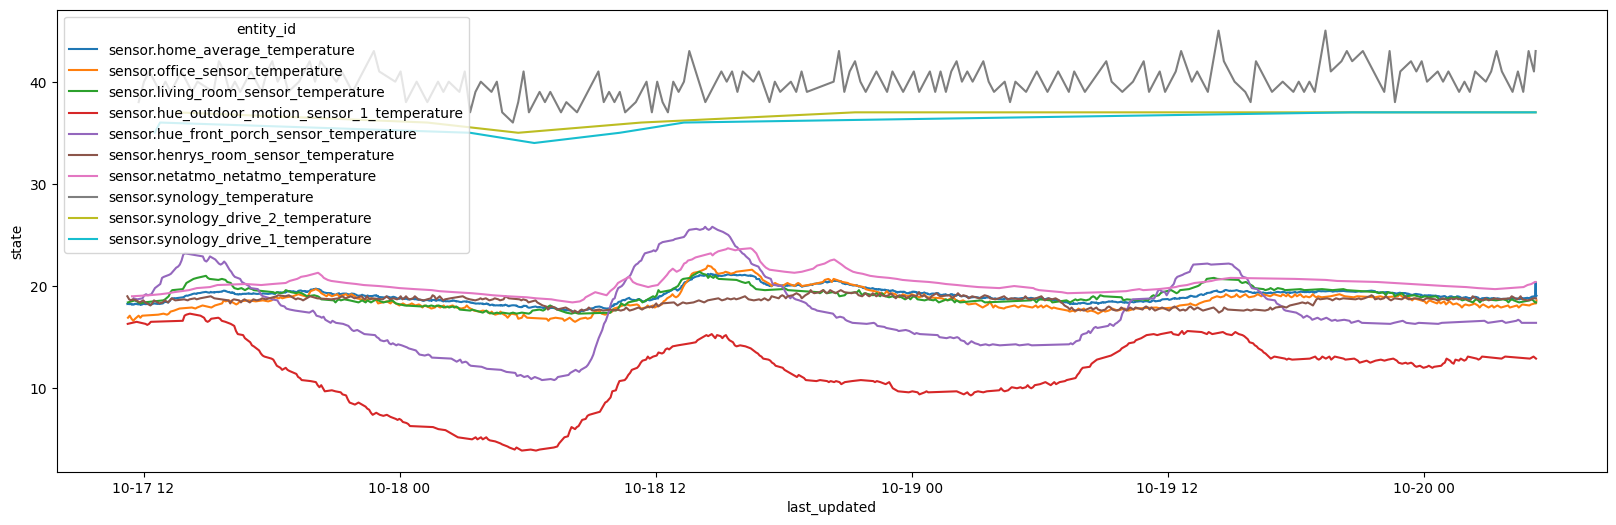

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(20,6))
sns.lineplot(
    x='last_updated', 
    y='state', 
    hue='entity_id', 
    data=df[df['is_temperature']], 
    ax=ax);

Now using [Altair](https://altair-viz.github.io/index.html)

In [16]:
# !pip install altair # Uncomment to install altair

In [17]:
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

alt.Chart(df[df['is_temperature']]).mark_line().encode(
    x='last_updated',
    y='state',
    color='entity_id',
    tooltip=['entity_id', 'state', 'last_updated']
).properties(
    width=800,
    height=300
).interactive()

/Users/robin/Github/HASS-data-detective/venv/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)